In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC32_emimTf2N_PR2 import configuration
data = pd.read_csv('R32_emimTf2N.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [4]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['emimTf2N','R32'] = -0.2009314111467241
m.fs.properties.PR_kappa_A['R32','emimTf2N'] = -0.056194263308478744
m.fs.properties.PR_kappa_B['emimTf2N','R32'] = 0.0
m.fs.properties.PR_kappa_B['R32','emimTf2N'] = 0.0

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data["x_emimTf2N"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.986
0.864
0.694
0.552
0.43
0.328
0.214
0.99
0.905
0.782
0.675
0.583
0.501
0.43
0.357
0.995
0.945
0.867
0.8
0.736
0.68
0.632
0.583
0.998
0.966
0.916
0.869
0.825
0.784
0.746
0.712


In [5]:
print(P)
print(data["pressure"])
print(R32_x)
print(data["x_R32"])

[   8794.43835225   90867.89231721  226733.3134848   369463.64619913
  525280.86997642  689476.64921385  916547.97468549    9758.28271885
   96630.61536201  237344.63294666  379001.46816435  520388.11246455
  666818.26072288  813733.56109982  989222.98616912    9100.00895267
  102559.73158436  258281.45763823  403458.12467238  554031.6918212
  697189.37898816  829927.72845945  976651.37803534    6062.28512336
  104739.02533915  265607.34873015  425107.95946042  582654.13029744
  737535.28367507  888907.44429225 1031484.62461668]
0       10200
1      100100
2      250300
3      399300
4      549300
5      700400
6      849400
7        9600
8       99800
9      250200
10     399400
11     549400
12     699500
13     849500
14     999700
15      10200
16     100300
17     249700
18     400100
19     549500
20     700300
21     850400
22    1000400
23      10300
24      99800
25     249700
26     399500
27     550300
28     699200
29     850400
30    1000500
Name: pressure, dtype: int64
[0

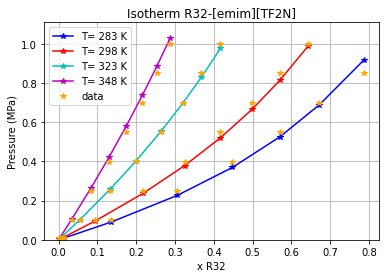

In [10]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m*-",label="T= 348 K")
plt.plot(data["x_R32"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

In [7]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -169.39 : False : (None, None)
    Pressure Change :  30985. : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    1.0000      0.14045       0.85955  
    mole_frac_comp emimTf2N    0.61200   1.0000e-08       0.71200  
    mole_frac_comp R32         0.38800       1.0000       0.28800  
    temperature                 348.05       348.05        348.05  
    pressure                1.0005e+06   1.0315e+06    1.0315e+06  


In [8]:
print(P1)

[0.00879444 0.09086789 0.22673331 0.36946365 0.52528087 0.68947665
 0.91654797 0.00975828 0.09663062 0.23734463 0.37900147 0.52038811
 0.66681826 0.81373356 0.98922299 0.00910001 0.10255973 0.25828146
 0.40345812 0.55403169 0.69718938 0.82992773 0.97665138 0.00606229
 0.10473903 0.26560735 0.42510796 0.58265413 0.73753528 0.88890744
 1.03148462]


In [9]:
df = pd.DataFrame(P)
df.to_csv('P_.csv')